In [1]:
# Loading necessary packages 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential

%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, f1_score,average_precision_score, confusion_matrix,
                             average_precision_score, precision_score, recall_score, roc_auc_score)
from mlxtend.plotting import plot_confusion_matrix

from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
# loading dataset
dataset = pd.read_csv("../input/xAPI-Edu-Data.csv")

In [3]:
# A summary of the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
gender                      480 non-null object
NationalITy                 480 non-null object
PlaceofBirth                480 non-null object
StageID                     480 non-null object
GradeID                     480 non-null object
SectionID                   480 non-null object
Topic                       480 non-null object
Semester                    480 non-null object
Relation                    480 non-null object
raisedhands                 480 non-null int64
VisITedResources            480 non-null int64
AnnouncementsView           480 non-null int64
Discussion                  480 non-null int64
ParentAnsweringSurvey       480 non-null object
ParentschoolSatisfaction    480 non-null object
StudentAbsenceDays          480 non-null object
Class                       480 non-null object
dtypes: int64(4), object(13)
memory usage: 63.8+ KB


In [4]:
# breif description of the numerical valued feature
dataset.describe()

,raisedhands,VisITedResources,AnnouncementsView,Discussion
count,480.000000,480.000000,480.000000,480.000000
mean,46.775000,54.797917,37.918750,43.283333
std,30.779223,33.080007,26.611244,27.637735
min,0.000000,0.000000,0.000000,1.000000
25%,15.750000,20.000000,14.000000,20.000000
50%,50.000000,65.000000,33.000000,39.000000
75%,75.000000,84.000000,58.000000,70.000000
max,100.000000,99.000000,98.000000,99.000000


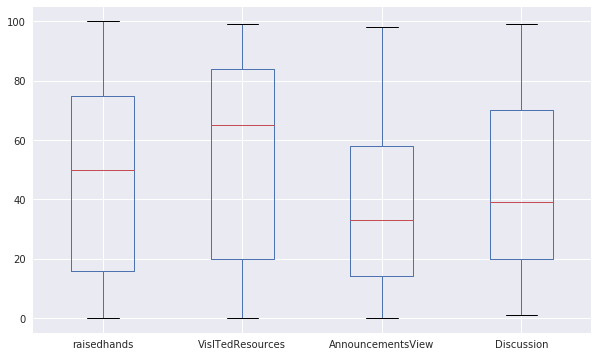

In [5]:
# checking outliers

plt.subplots(figsize=(10,6))
dataset.boxplot()
plt.show()

> ### Before jumping into __Data Cleaning__ and __Feature Engineering__ lets make a model based on only 3 features (raisedhands, VisITedResources, AnnouncementsView) described in this [paper](https://github.com/78526Nasir/Kaggle-Student-s-Academic-Performance/blob/master/related%20resarch%20paper/Classify%20the%20Category%20of%20Students%20%20p28-alam.pdf) as top/most effective variables

In [6]:
top_features = ["raisedhands","VisITedResources","AnnouncementsView", "Discussion"]
X = dataset[top_features]
y = dataset["Class"]

In [7]:
class_map = {"L":0, "M":1, "H":2}
y = y.map(class_map)

In [8]:
features_train, features_test, labels_train, labels_test = train_test_split(X, y, test_size = .15, random_state=40)

In [9]:
# model build with SVM.SVC classifier

clf = SVC(kernel = 'linear')
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy_score(pred, labels_test)

0.6666666666666666

In [10]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=1, leaf_size=10)
KNN.fit(features_train, labels_train)
KNNpred = clf.predict(features_test)
accuracy_score(KNNpred, labels_test)

0.6666666666666666

In [11]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy_score(pred, labels_test)

0.6944444444444444

In [12]:
# Random Forest Classifier with 200 subtrees

clf = RandomForestClassifier(n_estimators = 200)
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy_score(pred, labels_test)

0.6944444444444444

In [13]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy_score(pred, labels_test)

0.7083333333333334

In [14]:
# XGBoost Classifier

clf = XGBClassifier(max_depth=200, learning_rate=0.3, n_estimators=5, seed=1)
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy_score(pred, labels_test)

0.7777777777777778

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(pred, labels_test, labels=[1,0]))

[[26  2]
 [ 3 18]]


### actual True prediction
* TP = 26
* FN = 18

### actual False prediction
* FP = 2
* FN = 3

The model predicted __5__ observation wrongly.

In [16]:
print (classification_report(pred, labels_test, labels=[1, 0]))

             precision    recall  f1-score   support

          1       0.84      0.76      0.80        34
          0       0.82      0.82      0.82        22

avg / total       0.83      0.79      0.81        56



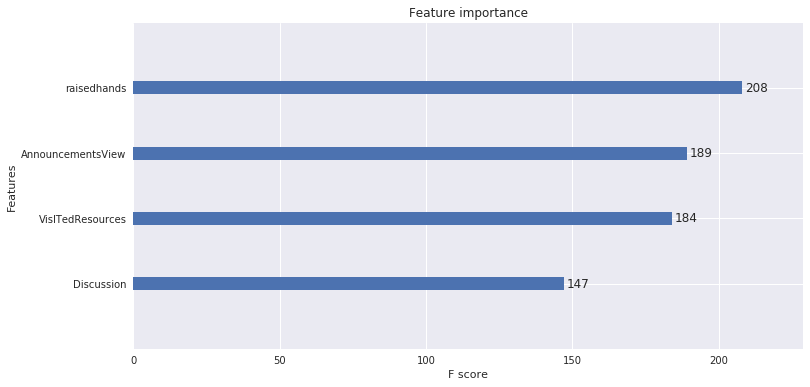

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
plot_importance(clf, ax = ax)

> ### Till now best accuracy on reduced features model: 0.78

## Now lets deep dive into the dataset and start cleaning the data and do some feature engineering

In [18]:
dataset.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [19]:
features = dataset.iloc[:,:-1]
labels = y

## Applying Integer Encoding only those Feature which have Natural Order

In [20]:
stageID_map = {"lowerlevel":0, "MiddleSchool":1, "HighSchool":2}
features["StageID"] = features["StageID"].map(stageID_map)

In [21]:
gradeID_map = {"G-02":0, "G-04":1, "G-05":2, "G-06":3, "G-07":4, "G-08":5, "G-09":6, "G-10":7, "G-11":8, "G-12":9}
features["GradeID"] = features["GradeID"].map(gradeID_map)

In [22]:
sectionID_map = {"A":0, "B":1, "C":2}
features["SectionID"] = features["SectionID"].map(sectionID_map)

In [23]:
del features["PlaceofBirth"]

## Applying One Hot Encoding rest of all

In [24]:
features = pd.get_dummies(features)
features.head()

,StageID,GradeID,SectionID,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_F,gender_M,NationalITy_Egypt,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,NationalITy_Morocco,NationalITy_Palestine,NationalITy_SaudiArabia,NationalITy_Syria,NationalITy_Tunis,NationalITy_USA,NationalITy_lebanon,NationalITy_venzuela,Topic_Arabic,Topic_Biology,Topic_Chemistry,Topic_English,Topic_French,Topic_Geology,Topic_History,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Semester_F,Semester_S,Relation_Father,Relation_Mum,ParentAnsweringSurvey_No,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Bad,ParentschoolSatisfaction_Good,StudentAbsenceDays_Above-7,StudentAbsenceDays_Under-7
0,0,1,0,15,16,2,20,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1
1,0,1,0,20,20,3,25,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1
2,0,1,0,10,7,0,30,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0
3,0,1,0,30,25,5,35,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0
4,0,1,0,40,50,12,50,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0


In [25]:
from  scipy.stats  import chisquare

result = pd.DataFrame(columns=["Features", "Chi2Weights"])

for i in range(len(features.columns)):
    chi2, p = chisquare(features[features.columns[i]])
    result = result.append([pd.Series([features.columns[i], chi2], index = result.columns)], ignore_index=True)

result = result.sort_values(by="Chi2Weights", ascending=False)

In [26]:
result.head(10)

,Features,Chi2Weights
3,raisedhands,9701.458044
4,VisITedResources,9565.389157
5,AnnouncementsView,8945.649085
6,Discussion,8453.172122
1,GradeID,1000.870968
22,NationalITy_venzuela,479.000000
15,NationalITy_Morocco,476.000000
10,NationalITy_Iran,474.000000
14,NationalITy_Lybia,474.000000
20,NationalITy_USA,474.000000


In [27]:
X = features
features_train, features_test, labels_train, labels_test = train_test_split(X, y, test_size = .20, random_state=0)

In [28]:
# model build with SVM.SVC classifier

clf = SVC(C=0.7, kernel = 'linear')
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy_score(pred, labels_test)

0.7916666666666666

In [29]:
clf = RandomForestClassifier(n_estimators = 100, random_state=42)
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
rfc_pred = pred
accuracy_score(pred, labels_test)

0.84375

In [30]:
clf = MLPClassifier(solver='lbfgs', alpha=0.00001, hidden_layer_sizes=(40,40,40), random_state=120)
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy_score(pred, labels_test)

0.7395833333333334

In [31]:
clf = XGBClassifier(max_depth=5, learning_rate=0.2, n_estimators=20, seed=0)
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
xgb_pred = pred
accuracy_score(pred, labels_test)

0.84375

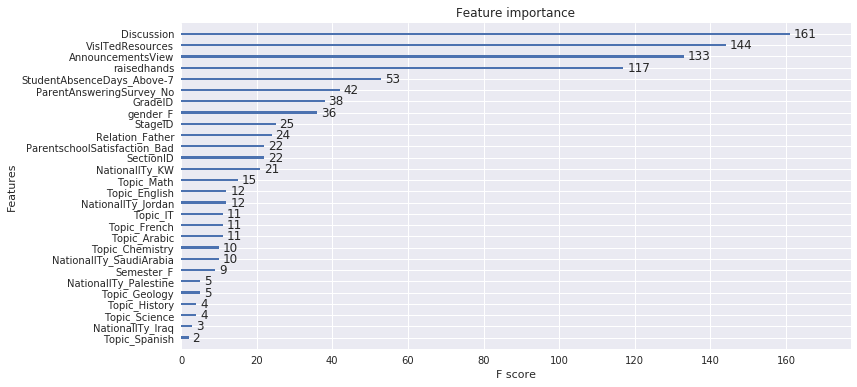

In [32]:
fig, ax = plt.subplots(figsize=(12,6))
plot_importance(clf, ax = ax)

In [33]:
# Random Forest Classifier confustion Matrix result
confusion_matrix(labels_test, rfc_pred, labels=[1, 0]) 

array([[38,  1],
       [ 0, 23]])

In [34]:
# XGBoost Classifier confusion matric result
confusion_matrix(labels_test, xgb_pred, labels=[1, 0]) 

array([[38,  2],
       [ 0, 23]])

### Till now highest Accuracy: 84.3%

## Feature Scaling

In [35]:
scaler  =  MinMaxScaler() 

bumpy_features = ["raisedhands", "VisITedResources", "AnnouncementsView",'Discussion']

df_scaled = pd.DataFrame(data = X)
df_scaled[bumpy_features] = scaler.fit_transform(X[bumpy_features])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:322: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [36]:
df_scaled.head()

,StageID,GradeID,SectionID,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_F,gender_M,NationalITy_Egypt,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,NationalITy_Morocco,NationalITy_Palestine,NationalITy_SaudiArabia,NationalITy_Syria,NationalITy_Tunis,NationalITy_USA,NationalITy_lebanon,NationalITy_venzuela,Topic_Arabic,Topic_Biology,Topic_Chemistry,Topic_English,Topic_French,Topic_Geology,Topic_History,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Semester_F,Semester_S,Relation_Father,Relation_Mum,ParentAnsweringSurvey_No,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Bad,ParentschoolSatisfaction_Good,StudentAbsenceDays_Above-7,StudentAbsenceDays_Under-7
0,0,1,0,0.15,0.161616,0.020408,0.193878,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1
1,0,1,0,0.20,0.202020,0.030612,0.244898,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1
2,0,1,0,0.10,0.070707,0.000000,0.295918,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0
3,0,1,0,0.30,0.252525,0.051020,0.346939,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0
4,0,1,0,0.40,0.505051,0.122449,0.500000,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0


## Over Sampling

In [37]:
X = df_scaled
sm  = SMOTE(random_state=7)
X_res, y_res = sm.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size= 0.15, random_state=7)

In [38]:
clf  =  XGBClassifier(max_depth = 10,random_state = 7, n_estimators=100, eval_metric = 'auc', min_child_weight = 3,
                    colsample_bytree = 0.75, subsample= 0.8)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="weighted"))
print("Recall:", recall_score(y_test, y_pred,  average="weighted"))
print("F1:", f1_score(y_test, y_pred, average="weighted"))

Accuracy: 0.8842105263157894
Precision: 0.8833082706766917
Recall: 0.8842105263157894
F1: 0.8827135304528188


In [39]:
confusion_matrix(y_test, y_pred, labels=[1, 0]) 

array([[26,  3],
       [ 1, 27]])

## Final Accuracy using ML classifier: 88.42%

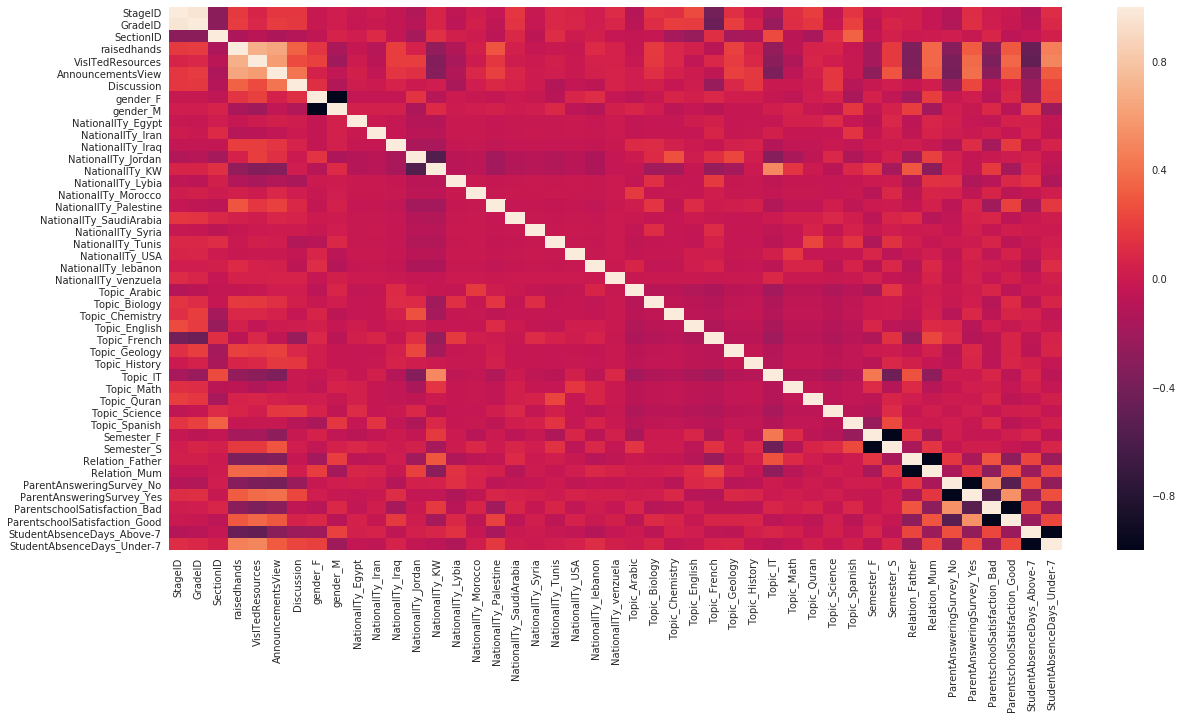

In [40]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(X.corr())

## Applying DL approach

In [41]:
y = dataset["Class"]
y = pd.get_dummies(y)
y.head()

,H,L,M
0,0,0,1
1,0,0,1
2,0,1,0
3,0,1,0
4,0,0,1


In [42]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=7)

learning_rate = 0.3
trainning_epochs = 1000
cost_history = np.empty(shape=[1], dtype=float)
n_dim = X.shape[1]

n_class = 3
model_path = "model"

In [43]:
n_hidden_1 = 60
n_hidden_2 = 60
n_hidden_3 = 60
n_hidden_4 = 60

In [44]:
x = tf.placeholder(tf.float32, [None, n_dim])
w = tf.Variable(tf.zeros([n_dim, n_class]))
b = tf.Variable(tf.zeros(n_class))
y_ = tf.placeholder(tf.float32, [None, n_class])

In [45]:
weights = {
    "h1" : tf.Variable(tf.truncated_normal([n_dim, n_hidden_1])),
    "h2" : tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2])),
    "h3" : tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3])),
    "h4" : tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_4])),
    "out" : tf.Variable(tf.truncated_normal([n_hidden_4, n_class]))
}

biases = {
    "b1" :  tf.Variable(tf.truncated_normal([n_hidden_1])),
    "b2" :  tf.Variable(tf.truncated_normal([n_hidden_2])),
    "b3" :  tf.Variable(tf.truncated_normal([n_hidden_3])),
    "b4" :  tf.Variable(tf.truncated_normal([n_hidden_4])),
    "out" :  tf.Variable(tf.truncated_normal([n_class]))
}

In [46]:
def multilayer_perceptron(x, weights, biases):
    
    # hidden layer with "relu" activation
    layer_1 = tf.add(tf.matmul(x, weights["h1"]), biases["b1"])
    layer_1 = tf.nn.sigmoid(layer_1)
    
    # hidden layer with "sigmoid" activation
    layer_2 = tf.add(tf.matmul(layer_1, weights["h2"]), biases["b2"])
    layer_2 = tf.nn.sigmoid(layer_2)
    
    # hidden layer with "sigmoid" activation
    layer_3 = tf.add(tf.matmul(layer_2, weights["h3"]), biases["b3"])
    layer_3 = tf.nn.sigmoid(layer_3)
    
    # hidden layer with "relu" activation
    layer_4 = tf.add(tf.matmul(layer_3, weights["h4"]), biases["b4"])
    layer_4 = tf.nn.relu(layer_4)
    
    out_layer = tf.matmul(layer_4, weights["out"]) + biases["out"]
    
    return out_layer

In [47]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
y = multilayer_perceptron(x, weights, biases)

cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y , labels = y_))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

In [48]:
sess = tf.Session()
sess.run(init)

In [49]:
mse_history = []
accuracy_history = []

for epoch in range(trainning_epochs):
    sess.run(training_step, feed_dict= {x: train_x, y_: train_y})
    cost = sess.run(cost_function, feed_dict = {x: train_x, y_:train_y})
    cost_history = np.append(cost_history, cost)
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    pred_y = sess.run(y, feed_dict={x : test_x})
    mse = tf.reduce_mean(tf.square(pred_y - test_y))
    mse_ = sess.run(mse)
    mse_history.append(mse_)
    accuracy = (sess.run(accuracy, feed_dict = {x : train_x, y_: train_y}))
    accuracy_history.append(accuracy)
    
    print ("epoch: ", epoch, "- cost: ", cost, "- MSE: ", mse_, "- Training Accuracy: ", accuracy)

epoch:  0 - cost:  40.304234 - MSE:  1266.7311 - Training Accuracy:  0.30092594
epoch:  1 - cost:  28.441494 - MSE:  491.12186 - Training Accuracy:  0.25925925
epoch:  2 - cost:  5.639307 - MSE:  69.554565 - Training Accuracy:  0.4351852
epoch:  3 - cost:  13.750203 - MSE:  96.41049 - Training Accuracy:  0.30092594
epoch:  4 - cost:  2.594804 - MSE:  11.109002 - Training Accuracy:  0.28935185
epoch:  5 - cost:  1.4056506 - MSE:  1.6213735 - Training Accuracy:  0.4398148
epoch:  6 - cost:  1.1357015 - MSE:  0.4919287 - Training Accuracy:  0.30324075
epoch:  7 - cost:  1.0778648 - MSE:  0.5251187 - Training Accuracy:  0.42824075
epoch:  8 - cost:  1.0690285 - MSE:  0.48222002 - Training Accuracy:  0.42592594
epoch:  9 - cost:  1.0633057 - MSE:  0.48941606 - Training Accuracy:  0.42824075
epoch:  10 - cost:  1.0579202 - MSE:  0.47889838 - Training Accuracy:  0.42824075
epoch:  11 - cost:  1.052526 - MSE:  0.47259474 - Training Accuracy:  0.42824075
epoch:  12 - cost:  1.046929 - MSE:  0.4

epoch:  103 - cost:  0.7041922 - MSE:  3.887163 - Training Accuracy:  0.6388889
epoch:  104 - cost:  0.71189815 - MSE:  4.421902 - Training Accuracy:  0.6388889
epoch:  105 - cost:  0.6784474 - MSE:  4.0430984 - Training Accuracy:  0.650463
epoch:  106 - cost:  0.682169 - MSE:  4.380867 - Training Accuracy:  0.6597222
epoch:  107 - cost:  0.66564214 - MSE:  4.126176 - Training Accuracy:  0.6689815
epoch:  108 - cost:  0.67514366 - MSE:  4.6699276 - Training Accuracy:  0.6828704
epoch:  109 - cost:  0.66435623 - MSE:  4.214208 - Training Accuracy:  0.6666667
epoch:  110 - cost:  0.6748722 - MSE:  4.8203206 - Training Accuracy:  0.6805556
epoch:  111 - cost:  0.67185044 - MSE:  4.372573 - Training Accuracy:  0.6643519
epoch:  112 - cost:  0.69156617 - MSE:  4.9437976 - Training Accuracy:  0.6550926
epoch:  113 - cost:  0.6902799 - MSE:  4.6011558 - Training Accuracy:  0.650463
epoch:  114 - cost:  0.72330624 - MSE:  5.2323804 - Training Accuracy:  0.6412037
epoch:  115 - cost:  0.6960542

epoch:  205 - cost:  0.6115761 - MSE:  6.601678 - Training Accuracy:  0.7106481
epoch:  206 - cost:  0.6269256 - MSE:  7.646784 - Training Accuracy:  0.7314815
epoch:  207 - cost:  0.602311 - MSE:  6.2755346 - Training Accuracy:  0.7175926
epoch:  208 - cost:  0.57127804 - MSE:  7.0562286 - Training Accuracy:  0.7569444
epoch:  209 - cost:  0.525842 - MSE:  6.504081 - Training Accuracy:  0.75
epoch:  210 - cost:  0.53218126 - MSE:  6.1317596 - Training Accuracy:  0.7638889
epoch:  211 - cost:  0.5512128 - MSE:  7.3526864 - Training Accuracy:  0.7430556
epoch:  212 - cost:  0.5922988 - MSE:  5.467892 - Training Accuracy:  0.7013889
epoch:  213 - cost:  0.54633415 - MSE:  7.366106 - Training Accuracy:  0.7476852
epoch:  214 - cost:  0.5353665 - MSE:  6.1813135 - Training Accuracy:  0.7453704
epoch:  215 - cost:  0.54242826 - MSE:  7.5079327 - Training Accuracy:  0.7523148
epoch:  216 - cost:  0.5741504 - MSE:  5.935747 - Training Accuracy:  0.712963
epoch:  217 - cost:  0.5363502 - MSE: 

epoch:  307 - cost:  0.44214204 - MSE:  10.189756 - Training Accuracy:  0.7939815
epoch:  308 - cost:  0.45244402 - MSE:  8.25252 - Training Accuracy:  0.7939815
epoch:  309 - cost:  0.4334868 - MSE:  10.007736 - Training Accuracy:  0.8032407
epoch:  310 - cost:  0.43449807 - MSE:  8.997539 - Training Accuracy:  0.8032407
epoch:  311 - cost:  0.44065264 - MSE:  9.622799 - Training Accuracy:  0.8101852
epoch:  312 - cost:  0.47358167 - MSE:  9.884233 - Training Accuracy:  0.7824074
epoch:  313 - cost:  0.5893409 - MSE:  9.256812 - Training Accuracy:  0.7592593
epoch:  314 - cost:  0.6235749 - MSE:  10.705836 - Training Accuracy:  0.7013889
epoch:  315 - cost:  0.5739223 - MSE:  8.6515875 - Training Accuracy:  0.7546296
epoch:  316 - cost:  0.67418796 - MSE:  11.072481 - Training Accuracy:  0.7060185
epoch:  317 - cost:  0.6585789 - MSE:  6.5857134 - Training Accuracy:  0.6759259
epoch:  318 - cost:  0.5103782 - MSE:  7.1353564 - Training Accuracy:  0.7662037
epoch:  319 - cost:  0.44710

epoch:  409 - cost:  0.3355493 - MSE:  11.918784 - Training Accuracy:  0.8657407
epoch:  410 - cost:  0.32059726 - MSE:  11.13894 - Training Accuracy:  0.8888889
epoch:  411 - cost:  0.32356498 - MSE:  12.597271 - Training Accuracy:  0.8611111
epoch:  412 - cost:  0.33667958 - MSE:  11.170561 - Training Accuracy:  0.8703704
epoch:  413 - cost:  0.37129903 - MSE:  12.9602375 - Training Accuracy:  0.8402778
epoch:  414 - cost:  0.40807748 - MSE:  10.487795 - Training Accuracy:  0.8240741
epoch:  415 - cost:  0.41588655 - MSE:  12.85088 - Training Accuracy:  0.8032407
epoch:  416 - cost:  0.4016489 - MSE:  9.936612 - Training Accuracy:  0.8101852
epoch:  417 - cost:  0.3404913 - MSE:  12.128391 - Training Accuracy:  0.8611111
epoch:  418 - cost:  0.3153683 - MSE:  10.902963 - Training Accuracy:  0.8796296
epoch:  419 - cost:  0.31059787 - MSE:  12.506753 - Training Accuracy:  0.8796296
epoch:  420 - cost:  0.31132564 - MSE:  11.24992 - Training Accuracy:  0.8865741
epoch:  421 - cost:  0.

epoch:  510 - cost:  0.3220986 - MSE:  16.359785 - Training Accuracy:  0.8587963
epoch:  511 - cost:  0.36896092 - MSE:  13.531957 - Training Accuracy:  0.8402778
epoch:  512 - cost:  0.44243824 - MSE:  16.992447 - Training Accuracy:  0.7939815
epoch:  513 - cost:  0.49930382 - MSE:  12.152062 - Training Accuracy:  0.7662037
epoch:  514 - cost:  0.38167882 - MSE:  14.721836 - Training Accuracy:  0.8333333
epoch:  515 - cost:  0.3088785 - MSE:  11.889572 - Training Accuracy:  0.8680556
epoch:  516 - cost:  0.2525729 - MSE:  14.989227 - Training Accuracy:  0.9143519
epoch:  517 - cost:  0.24159183 - MSE:  14.180796 - Training Accuracy:  0.9189815
epoch:  518 - cost:  0.23787525 - MSE:  15.220917 - Training Accuracy:  0.9166667
epoch:  519 - cost:  0.23348382 - MSE:  14.749498 - Training Accuracy:  0.9189815
epoch:  520 - cost:  0.23032351 - MSE:  15.258209 - Training Accuracy:  0.9236111
epoch:  521 - cost:  0.22847092 - MSE:  14.9290905 - Training Accuracy:  0.9259259
epoch:  522 - cost

epoch:  611 - cost:  0.23877312 - MSE:  19.07078 - Training Accuracy:  0.9097222
epoch:  612 - cost:  0.25862262 - MSE:  17.779057 - Training Accuracy:  0.8912037
epoch:  613 - cost:  0.28072307 - MSE:  19.565172 - Training Accuracy:  0.8842593
epoch:  614 - cost:  0.34465843 - MSE:  18.14349 - Training Accuracy:  0.8611111
epoch:  615 - cost:  0.49602473 - MSE:  21.693335 - Training Accuracy:  0.7800926
epoch:  616 - cost:  0.7308961 - MSE:  18.363426 - Training Accuracy:  0.7314815
epoch:  617 - cost:  0.61310107 - MSE:  16.101604 - Training Accuracy:  0.6851852
epoch:  618 - cost:  0.3828672 - MSE:  14.518455 - Training Accuracy:  0.8194444
epoch:  619 - cost:  0.36153913 - MSE:  11.270165 - Training Accuracy:  0.8449074
epoch:  620 - cost:  0.22418076 - MSE:  16.318682 - Training Accuracy:  0.9212963
epoch:  621 - cost:  0.2060116 - MSE:  16.573002 - Training Accuracy:  0.9328704
epoch:  622 - cost:  0.19694246 - MSE:  17.948236 - Training Accuracy:  0.9282407
epoch:  623 - cost:  

epoch:  712 - cost:  0.14534217 - MSE:  23.577467 - Training Accuracy:  0.9513889
epoch:  713 - cost:  0.15886085 - MSE:  20.840889 - Training Accuracy:  0.9467593
epoch:  714 - cost:  0.14628994 - MSE:  23.976162 - Training Accuracy:  0.9537037
epoch:  715 - cost:  0.15954399 - MSE:  20.877869 - Training Accuracy:  0.9421296
epoch:  716 - cost:  0.14682013 - MSE:  24.18354 - Training Accuracy:  0.9513889
epoch:  717 - cost:  0.15609753 - MSE:  21.164337 - Training Accuracy:  0.9421296
epoch:  718 - cost:  0.15533377 - MSE:  24.63494 - Training Accuracy:  0.9421296
epoch:  719 - cost:  0.19705972 - MSE:  20.184626 - Training Accuracy:  0.9189815
epoch:  720 - cost:  0.23705088 - MSE:  25.875538 - Training Accuracy:  0.900463
epoch:  721 - cost:  0.45304123 - MSE:  18.321754 - Training Accuracy:  0.8078704
epoch:  722 - cost:  0.66799974 - MSE:  28.593174 - Training Accuracy:  0.7175926
epoch:  723 - cost:  1.1199144 - MSE:  13.799955 - Training Accuracy:  0.5393519
epoch:  724 - cost: 

epoch:  813 - cost:  0.12079731 - MSE:  28.475925 - Training Accuracy:  0.9560185
epoch:  814 - cost:  0.12197032 - MSE:  27.360277 - Training Accuracy:  0.9652778
epoch:  815 - cost:  0.11889638 - MSE:  28.614492 - Training Accuracy:  0.962963
epoch:  816 - cost:  0.119191885 - MSE:  27.65716 - Training Accuracy:  0.9652778
epoch:  817 - cost:  0.116722636 - MSE:  28.69236 - Training Accuracy:  0.962963
epoch:  818 - cost:  0.11707739 - MSE:  27.913544 - Training Accuracy:  0.9652778
epoch:  819 - cost:  0.11457252 - MSE:  28.871124 - Training Accuracy:  0.9606481
epoch:  820 - cost:  0.11556784 - MSE:  28.075872 - Training Accuracy:  0.9652778
epoch:  821 - cost:  0.11368324 - MSE:  28.949745 - Training Accuracy:  0.9606481
epoch:  822 - cost:  0.11480241 - MSE:  28.253096 - Training Accuracy:  0.9675926
epoch:  823 - cost:  0.11351896 - MSE:  28.970028 - Training Accuracy:  0.9606481
epoch:  824 - cost:  0.11398036 - MSE:  28.450758 - Training Accuracy:  0.9699074
epoch:  825 - cost

epoch:  914 - cost:  0.3167259 - MSE:  17.386265 - Training Accuracy:  0.8958333
epoch:  915 - cost:  0.30244583 - MSE:  17.594898 - Training Accuracy:  0.9050926
epoch:  916 - cost:  0.2922733 - MSE:  19.848463 - Training Accuracy:  0.9097222
epoch:  917 - cost:  0.32411933 - MSE:  18.075676 - Training Accuracy:  0.8726852
epoch:  918 - cost:  0.2626654 - MSE:  20.613424 - Training Accuracy:  0.9259259
epoch:  919 - cost:  0.2692805 - MSE:  20.120518 - Training Accuracy:  0.9097222
epoch:  920 - cost:  0.27168453 - MSE:  23.21914 - Training Accuracy:  0.9166667
epoch:  921 - cost:  0.35042006 - MSE:  19.777292 - Training Accuracy:  0.8680556
epoch:  922 - cost:  0.2349861 - MSE:  22.87072 - Training Accuracy:  0.9444444
epoch:  923 - cost:  0.22404362 - MSE:  23.423811 - Training Accuracy:  0.9328704
epoch:  924 - cost:  0.21804784 - MSE:  25.722868 - Training Accuracy:  0.9375
epoch:  925 - cost:  0.249244 - MSE:  23.227282 - Training Accuracy:  0.9212963
epoch:  926 - cost:  0.18752

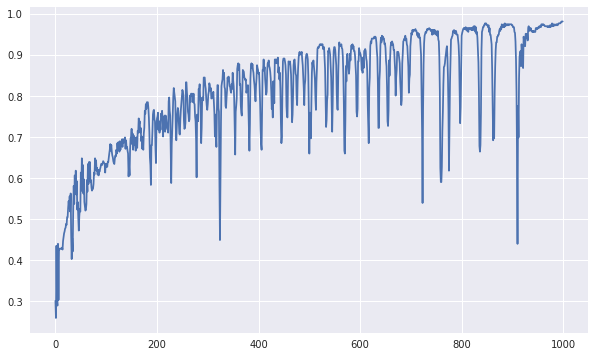

In [50]:
plt.subplots(figsize=(10, 6))
plt.plot(accuracy_history)
plt.show()

In [51]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print("Test Accuracy : ", (sess.run(accuracy, feed_dict = {x: test_x, y_:test_y})))

Test Accuracy :  0.8541667


## Final Accuracy using Multilayer Perceptron: 85.41%